In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [3]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype = torch.float16,cache_dir="./hf_cache")
# control_model = ControlModel(model, list(range(-5,-18,-1)))

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir="./hf_cache"
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [5]:
from repeng import DatasetEntry
from typing import List

def make_dataset(
    template:str,
    pos_personas: List[str],
    neg_personas: List[str],
    suffixes: List[str],
) -> List[DatasetEntry]:
    dataset: List[DatasetEntry] = []
    for suffix in suffixes:
        for pos, neg in zip(pos_personas, neg_personas):
            positive_prompt = template.format(persona=pos) + " " + suffix
            negative_prompt = template.format(persona=neg) + " " + suffix
            dataset.append(DatasetEntry(positive = positive_prompt, negative = negative_prompt))

    return dataset

In [9]:
truncated_output_suffixes = [
    "Alice lived in paris from 2012 to 2017. Bob lived in paris from 2020 to 2023. Options : A) Alice B) Bob"
]

In [10]:
trippy_dataset = make_dataset(
    "Based on the given information find {persona}",
    ["who lived to paris first."],
    ["who lived to paris last."],
    truncated_output_suffixes
)

In [11]:
trippy_dataset

[DatasetEntry(positive='Based on the given information find who lived to paris first. Alice lived in paris from 2012 to 2017. Bob lived in paris from 2020 to 2023. Options : A) Alice B) Bob', negative='Based on the given information find who lived to paris last. Alice lived in paris from 2012 to 2017. Bob lived in paris from 2020 to 2023. Options : A) Alice B) Bob')]

In [ ]:
from repeng import ControlVector

trippy_vector = ControlVector.train(model, tokenizer, trippy_dataset)

In [15]:
trippy_dataset[0].positive

'Based on the given information find who lived to paris first. Alice lived in paris from 2012 to 2017. Bob lived in paris from 2020 to 2023. Options : A) Alice B) Bob'

In [25]:
from repeng.extract import batched_get_hiddens
from repeng.control import model_layer_list

texts = []
texts.append(trippy_dataset[0].positive)
texts.append(trippy_dataset[0].negative)

layers_e = model_layer_list(model)

layers = [i  for i in range(len(layers_e))]

hiddens = batched_get_hiddens(model, tokenizer, texts, layers, batch_size=2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.75s/it]


In [30]:
import numpy as np
attributions = {}
for layer in layers[:-1]:
    direction = trippy_vector.directions[layer+1] / np.linalg.norm(trippy_vector.directions[layer+1])
    activations = hiddens[layer]  # (num_texts, hidden_dim)
    
    # Projection score (alignment with concept)
    attribution = activations @ direction
    print(layer, attribution)
    attributions[layer] = attribution

0 [-0.00503159 -0.0050354 ]
1 [-0.00177002 -0.00181007]
2 [-0.00927734 -0.00934601]
3 [-0.01739502 -0.01751709]
4 [-0.01593018 -0.01641846]
5 [-0.01197052 -0.01288605]
6 [ 0.00065613 -0.001297  ]
7 [0.00888824 0.00156784]
8 [-0.02420044 -0.01911926]
9 [0.01881409 0.01075745]
10 [0.10900879 0.08459473]
11 [0.07965088 0.05627441]
12 [0.11743164 0.10302734]
13 [0.10113525 0.08642578]
14 [-0.12756348 -0.11938477]
15 [-0.14526367 -0.15405273]
16 [-0.1328125  -0.15771484]
17 [-0.15112305 -0.1697998 ]
18 [ 0.00085449 -0.02807617]
19 [0.10705566 0.07458496]
20 [-0.09283447 -0.13134766]
21 [-0.06628418 -0.12890625]
22 [-0.07489014 -0.13671875]
23 [-0.04162598 -0.0836792 ]
24 [0.23046875 0.2006836 ]
25 [0.20678711 0.16137695]
26 [0.22460938 0.21704102]
27 [0.2758789 0.2644043]
28 [0.2861328  0.27612305]
29 [-0.38598633 -0.38427734]
30 [-0.09802246 -0.19799805]


In [31]:
attributions

{0: array([-0.00503159, -0.0050354 ], dtype=float32),
 1: array([-0.00177002, -0.00181007], dtype=float32),
 2: array([-0.00927734, -0.00934601], dtype=float32),
 3: array([-0.01739502, -0.01751709], dtype=float32),
 4: array([-0.01593018, -0.01641846], dtype=float32),
 5: array([-0.01197052, -0.01288605], dtype=float32),
 6: array([ 0.00065613, -0.001297  ], dtype=float32),
 7: array([0.00888824, 0.00156784], dtype=float32),
 8: array([-0.02420044, -0.01911926], dtype=float32),
 9: array([0.01881409, 0.01075745], dtype=float32),
 10: array([0.10900879, 0.08459473], dtype=float32),
 11: array([0.07965088, 0.05627441], dtype=float32),
 12: array([0.11743164, 0.10302734], dtype=float32),
 13: array([0.10113525, 0.08642578], dtype=float32),
 14: array([-0.12756348, -0.11938477], dtype=float32),
 15: array([-0.14526367, -0.15405273], dtype=float32),
 16: array([-0.1328125 , -0.15771484], dtype=float32),
 17: array([-0.15112305, -0.1697998 ], dtype=float32),
 18: array([ 0.00085449, -0.0280

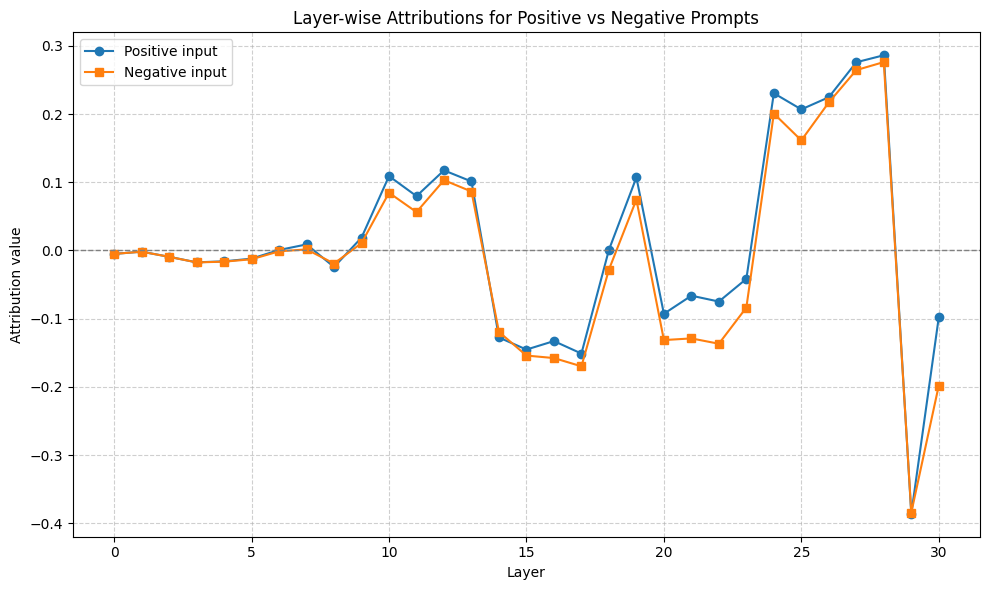

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# assuming your dict is called `attributions`
# each value is an array of shape (2,) — one for each input
layers = list(attributions.keys())
values = np.array([attributions[l] for l in layers])  # shape (num_layers, 2)

# Separate the two attribution series
attr_pos = values[:, 0]
attr_neg = values[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(layers, attr_pos, marker='o', label='Positive input')
plt.plot(layers, attr_neg, marker='s', label='Negative input')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title("Layer-wise Attributions for Positive vs Negative Prompts")
plt.xlabel("Layer")
plt.ylabel("Attribution value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
def batched_get_token_hiddens(model, tokenizer, inputs, hidden_layers, batch_size=2):
    """
    Same as repeng.control.batched_get_hiddens, but returns hidden states for *every token*.
    Output: dict[layer] = list of arrays, each (seq_len_i, hidden_dim)
    """
    batched_inputs = [inputs[p:p + batch_size] for p in range(0, len(inputs), batch_size)]
    hidden_states = {layer: [] for layer in hidden_layers}

    with torch.no_grad():
        for batch in tqdm.tqdm(batched_inputs, desc="extracting token-wise hiddens"):
            encoded_batch = tokenizer(batch, padding=True, return_tensors="pt").to(model.device)
            out = model(**encoded_batch, output_hidden_states=True)
            attention_mask = encoded_batch["attention_mask"]

            for i in range(len(batch)):
                seq_len = int(attention_mask[i].sum().item())
                for layer in hidden_layers:
                    hidden_idx = layer + 1 if layer >= 0 else layer
                    hidden = out.hidden_states[hidden_idx][i, :seq_len, :].cpu().float().numpy()
                    hidden_states[layer].append(hidden)
            del out

    return hidden_states

In [ ]:
token_hiddens = batched_get_token_hiddens(model, tokenizer, texts, hidden_layers=list(range(model.config.num_hidden_layers)))

In [72]:
tokenwise_attributions = []
# For example, layer = 10
for layer in layers[:-1]:
    direction = trippy_vector.directions[layer+1] / np.linalg.norm(trippy_vector.directions[layer+1])
    
    # Compute projection for each token in each input
    t_attr = []
    for seq_hidden in token_hiddens[layer]:  # one per input sentence
        # shape: (seq_len, hidden_dim)
        proj = seq_hidden @ direction
        t_attr.append(proj)
    tokenwise_attributions.append(t_attr)

In [75]:
len(tokenwise_attributions[0][1])

58

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tokenwise_attributions(tokenwise_attributions, texts, tokenizer, layer=10):
    """
    tokenwise_attributions: list of arrays [(seq_len_i,), ...] for each input
    texts: list of input strings
    tokenizer: the same tokenizer used for encoding
    layer: layer number (only for title)
    """

    plt.figure(figsize=(12, 5))
    colors = ["tab:blue", "tab:red"]
    labels = ["Positive input", "Negative input"]

    for i, (attribs, text) in enumerate(zip(tokenwise_attributions[layer], texts)):
        tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])
        x = np.arange(len(tokens))
        plt.plot(x, attribs, marker="o", label=labels[i], color=colors[i], linewidth=1.8)
        # print token text below points
        for xi, tok in zip(x, tokens):
            plt.text(xi, -0.02, tok, ha="center", va="top", rotation=90, fontsize=8)

    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Token-wise attribution (Layer {layer})")
    plt.xlabel("Token position")
    plt.ylabel("Attribution value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


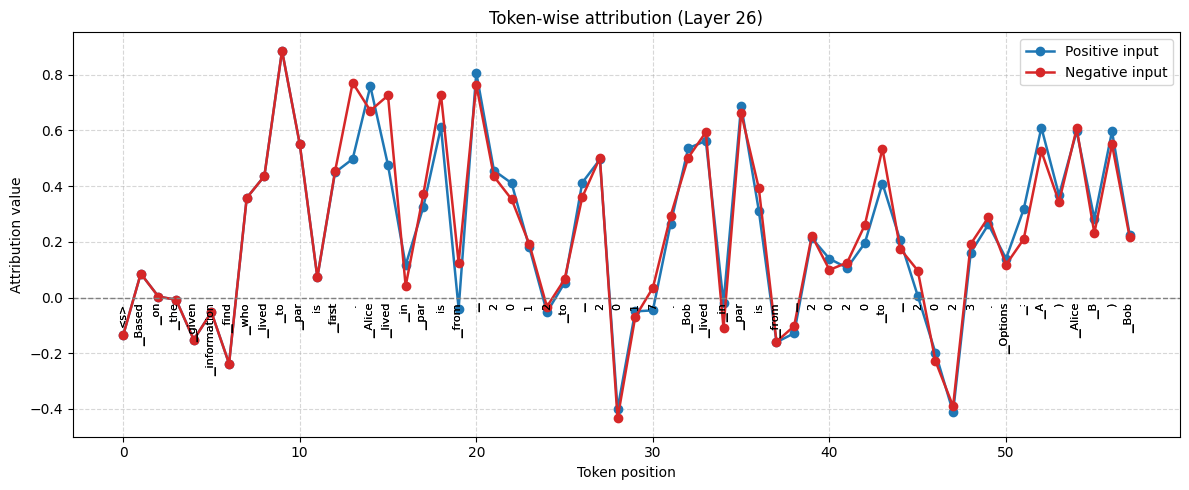

In [78]:
plot_tokenwise_attributions(tokenwise_attributions, texts, tokenizer, layer=26)

In [50]:
len(token_hiddens[0][0])

58

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
from IPython.display import display, HTML

def show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=10):
    """
    Show each token colored from green→black→red according to attribution value.
    Green = strongly negative, Black = near zero, Red = strongly positive.
    """
    cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red

    html_output = f"<h3>Token-wise Attribution Coloring (Layer {layer})</h3>"
    for i, (attribs, text) in enumerate(zip(tokenwise_attributions[layer], texts)):
        tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])
        # normalize attribution values to [0,1]
        norm = colors.Normalize(vmin=-np.max(np.abs(attribs)), vmax=np.max(np.abs(attribs)))
        color_vals = cmap(norm(attribs))

        html_output += f"<p><b>Text {i}:</b><br>"
        for tok, color in zip(tokens, color_vals):
            rgba = tuple(int(255*c) for c in color[:3])
            html_output += f"<span style='background-color: rgb{rgba}; font-weight: bold; text-decoration: None;'>{tok} </span>"
        html_output += "</p>"

    display(HTML(html_output))


In [80]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=10)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red


In [81]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=12)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red


In [82]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=19)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red


In [83]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=24)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red


In [84]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=26)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red


In [85]:
show_colored_tokens(tokenwise_attributions, texts, tokenizer, layer=28)

/tmp/ipykernel_3672571/2102659056.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")  # reversed so negative=green, positive=red
